# Подготовка данных

## Описание датасета
Для выполнения задания предоставляется история покупок клиентов за определенный период времени, а также вспомогательные метаданные. Задача состоит в том, чтобы предсказать, какие товары купит каждый покупатель в течение 7 дней сразу после окончания обучающих данных. Клиенты, не совершившие ни одной покупки в течение этого времени, исключаются из подсчета очков.

## Содержание
- __images/__ - Папка с папками, наименования которых соответсвуют первым 3 цифрам article_id, которые расположены внутри;
- __article.csv__ — Пдробные метаданные для каждого article_id, доступного для покупки;
- __customers.csv__ — Метаданные для каждого customer_id в наборе данных;
- __sample_submission.csv__ — Образец решения для Kaggle;
- __transaction_train.csv__ — Обучающие данные.

## Библиотеки

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from utils import HM

## Загрузка данных

In [ ]:
hm = HM()

articles = hm.get_articles()
customers = hm.get_customers()
sample_submission = hm.get_sample_submission()
transactions_train = hm.get_transactions_train()

## Составление датасета для решения задачи

### Сделаем подсчет рейтинга для каждого товара из файла с транзакциями

In [15]:
article_count = transactions_train['article_id'].value_counts()

In [16]:
article_count

706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
             ...  
520736002        1
619777003        1
586904003        1
512385003        1
533261032        1
Name: article_id, Length: 104547, dtype: int64

In [17]:
articles_with_rating = articles.merge(article_count, how='left', left_on='article_id', right_index=True).rename(columns={'article_id_x': 'article_id', 'article_id_y': 'rating'})
articles_with_rating['rating'] = articles_with_rating['rating'].fillna(0)
articles_with_rating = articles_with_rating.sort_values(by='rating', ascending=False)

_P.S. Привет из будущего. Такой вариант рейтинга идеально соотвествует значениям из sample_submission. Так что прямо сейчас чуть улучшим алгоритм подсчета рейтинга_

### Определим пол для каждого клиента

Определять будем также на основе файла `transactions_train`

In [18]:
womens = articles['section_name'].str.contains('Women').map(lambda x: 'W' if x else np.NaN).dropna()
girl = articles['section_name'].str.contains('Girl').map(lambda x: 'W' if x else np.NaN).dropna()
mens = articles['section_name'].str.contains('Men').map(lambda x: 'M' if x else np.NaN).dropna()
boy = articles['section_name'].str.contains('Boy').map(lambda x: 'M' if x else np.NaN).dropna()

In [19]:
articles_with_gender = articles.copy()
articles_with_gender['gender'] = pd.concat([womens, girl, mens, boy])

In [20]:
articles_with_gender['gender'] = articles_with_gender['gender'].fillna('Other')

In [21]:
transactions_train_with_gender = transactions_train.merge(articles_with_gender[['article_id', 'gender']], on='article_id', how='left')

In [22]:
# customers_with_gender = transactions_train_with_gender.groupby('customer_id')['gender'].apply(lambda x: x.describe().top)

In [23]:
# customers_with_gender.to_csv('./data_prepared/customers.csv')

In [24]:
customers_with_gender = pd.read_csv('./data_prepared/customers.csv')

_P.S. Привет из будущего. Пол не помог улучшить предсказание покупок. Ну или криво вычленили пол из набора данных_. Попробуем тогда разделить пользователей на группы людей по возрасту.

### Определим возрастные группы для каждого клиента

Согласно классификации Всемирной организации здравоохранения возраст человека делится на несколько периодов:
1. 0-44 - Молодой;
2. 45-59 – Средний;
3. 60-74 – Пожилой;
4. 75-89 – Старческий;
5. 90-100 - Долгожитель.

In [41]:
young_index = customers[customers['age'] < 45].index
medium_index = customers[(customers['age'] > 44) & (customers['age'] < 60)].index
elderly_index = customers[(customers['age'] > 59) & (customers['age'] < 75)].index
senile_index = customers[(customers['age'] > 74) & (customers['age'] < 90)].index
long_live_index = customers[customers['age'] > 89].index

In [44]:
customers_with_age_group = customers.copy()

In [45]:
customers_with_age_group['age_group'] = np.nan

In [48]:
customers_with_age_group.loc[young_index, 'age_group'] = 'YOUNG'
customers_with_age_group.loc[medium_index, 'age_group'] = 'MEDIUM'
customers_with_age_group.loc[elderly_index, 'age_group'] = 'ELDERLY'
customers_with_age_group.loc[senile_index, 'age_group'] = 'SENILE'
customers_with_age_group.loc[long_live_index, 'age_group'] = 'LONG_LIVE'

In [49]:
customers_with_age_group

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,MEDIUM
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,YOUNG
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,YOUNG
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,MEDIUM
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,MEDIUM
...,...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...,YOUNG
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...,YOUNG
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...,YOUNG
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...,YOUNG


In [54]:
# customers_with_age_group_gender = customers_with_age_group.merge(customers_with_gender['gender'], left_index=True, right_index=True, how='left')

In [55]:
# customers_with_age_group_gender.set_index('customer_id').to_csv('./data_prepared/customers.csv')

In [56]:
customers_with_age_group_gender = pd.read_csv('./data_prepared/customers.csv')

In [57]:
customers_with_age_group_gender['age_group'].value_counts()

YOUNG        919502
MEDIUM       344867
ELDERLY       85766
SENILE         5883
LONG_LIVE       101
Name: age_group, dtype: int64

### Добавим цену для каждого товара

Ценой будем считать среднее значение признака price для одного article_id из файла transactions_train 

In [25]:
prices = transactions_train.groupby('article_id')['price'].mean()
articles_with_rating_price = articles_with_rating.merge(prices, how='left', left_on='article_id', right_index=True)
articles_with_rating_price['price'] = articles_with_rating_price['price'].fillna(articles_with_rating_price['price'].mean())

articles_with_rating_price = articles_with_rating_price.merge(articles_with_gender['gender'], left_index=True, right_index=True, how='left')

Посмотрим на корреляцию

<AxesSubplot:>

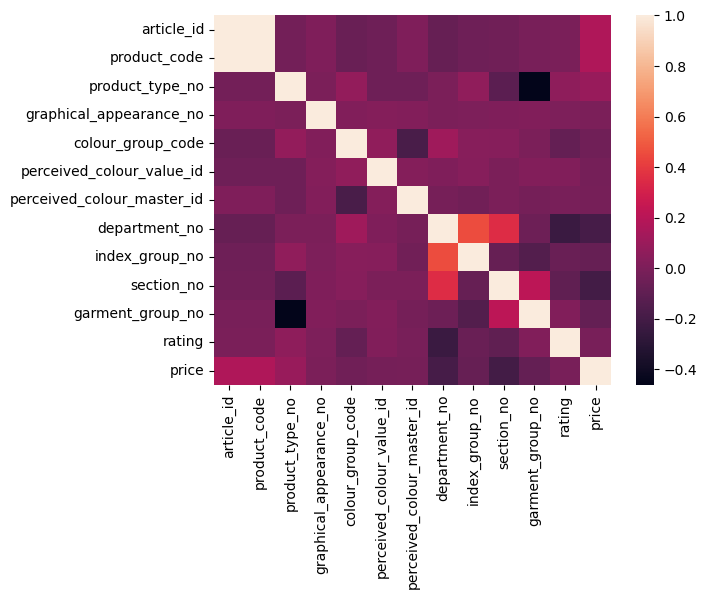

In [26]:
corr = articles_with_rating_price.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [27]:
#  Глянем только на те товары, которые покупали. Иначе не интересно
top_articles = articles_with_rating_price[articles_with_rating_price['rating'] > 0][:5]
worst_products = articles_with_rating_price[articles_with_rating_price['rating'] > 0][-5:]

In [28]:
top_articles[['product_type_name', 'rating', 'price']]

,product_type_name,rating,price
53892,Trousers,50287.0,0.032448
53893,Trousers,35043.0,0.032426
1713,Socks,31718.0,0.012958
24837,T-shirt,30199.0,0.008083
70221,Vest top,26329.0,0.005605


In [29]:
worst_products[['product_type_name', 'rating', 'price']]

,product_type_name,rating,price
6564,Leggings/Tights,1.0,0.004559
100710,Garment Set,1.0,0.033881
12414,T-shirt,1.0,0.022017
95015,Garment Set,1.0,0.046407
5939,Trousers,1.0,0.047441


__Вывод__

Самые популряные товары представляют из себя:
1. Штаны;
2. Носки;
3. Футболки;
4. Безрукавки.

Самые __не__ популярные товары (рейтинг != 0):
1. Леггинсы/Колготки;
2. Комплект одежды;
3. Футболки.

Самые __не__ популярные товары (рейтинг = 0):
1. Футболки;
2. Боди;
3. Свитер;
4. Платье.

Линейной зависимости рейтинга с другими признаками не обнаружено. Даже с ценой.

Сохраним articles_with_rating_price в папку data_prepared для последущей работы с этим файлом

In [30]:
articles_with_rating_price.set_index('article_id').to_csv('./data_prepared/articles.csv')